In [1]:
# Traffic Sign Dataset Exploration and Visualization

# This notebook provides a comprehensive exploration and visualization of the traffic sign dataset used for our CNN classification model.

# Table of Contents
# 1. Setup and Data Loading
# 2. Dataset Overview
# 3. Class Distribution
# 4. Image Visualization
# 5. Image Properties Analysis
# 6. Data Augmentation Preview
# 7. Conclusions and Next Steps

# 1. Setup and Data Loading

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import os
import tensorflow as tf
from tensorflow import keras

In [3]:
#Data Exploration
import os

# Define dataset paths
train_dir = os.path.normpath('../data/train')
valid_dir = os.path.normpath('../data/valid')
test_dir = os.path.normpath('../data/test')

# Function to get class info and extract first number from label files
def get_class_info(directory):
    image_dir = os.path.normpath(os.path.join(directory, 'images'))
    label_dir = os.path.normpath(os.path.join(directory, 'labels'))
    
    # Count images
    image_count = len([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    
    # Extract first number from label files
    labels = set()
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(label_dir, filename), 'r') as f:
                first_line = f.readline().strip()
                if first_line:
                    first_number = first_line.split()[0]
                    labels.add(first_number)
    
    return image_count, sorted(list(labels))

# Get info for each dataset
train_count, train_labels = get_class_info(train_dir)
valid_count, valid_labels = get_class_info(valid_dir)
test_count, test_labels = get_class_info(test_dir)

# Print results
print(f"Number of training images: {train_count}")
print(f"Number of validation images: {valid_count}")
print(f"Number of test images: {test_count}")

print(f"\nUnique labels in training set: {train_labels}")
print(f"Unique labels in validation set: {valid_labels}")
print(f"Unique labels in test set: {test_labels}")

Number of training images: 3527
Number of validation images: 801
Number of test images: 637

Unique labels in training set: ['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']
Unique labels in validation set: ['0', '1', '10', '11', '12', '13', '14', '3', '4', '5', '6', '7', '8', '9']
Unique labels in test set: ['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
#Data Loader & Preprocessing 
import os
import tensorflow as tf
from tensorflow import keras

# Define dataset paths
train_dir = os.path.normpath('../data/train')
valid_dir = os.path.normpath('../data/valid')
test_dir = os.path.normpath('../data/test')

def create_dataset(directory, batch_size=32, image_size=(224, 224), shuffle=True):
    image_dir = os.path.join(directory, 'images')
    label_dir = os.path.join(directory, 'labels')
    
    dataset = tf.data.Dataset.list_files(os.path.join(image_dir, '*'), shuffle=shuffle)
    
    def process_path(file_path):
        # Load and preprocess the image
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_size)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        
        # Get corresponding label file
        label_file = tf.strings.regex_replace(file_path, 'images', 'labels')
        label_file = tf.strings.regex_replace(label_file, r'\.(jpg|jpeg|png|bmp)', '.txt')
        
        # Read and process the label
        label_content = tf.io.read_file(label_file)
        label = tf.strings.split(label_content, sep='\n')[0]
        label = tf.strings.split(label, sep=' ')[0]
        
        # Convert label to number, with error handling
        label = tf.strings.to_number(label, out_type=tf.float32, name="label_to_number")
        label = tf.where(tf.math.is_finite(label), tf.cast(label, tf.int32), tf.constant(-1, dtype=tf.int32))
        
        return img, label

    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda x, y: y >= 0)  # Remove entries with invalid labels
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

    def print_label_samples(directory, num_samples=10):
        label_dir = os.path.join(directory, 'labels')
        label_files = os.listdir(label_dir)[:num_samples]
    
        print(f"Sample of {num_samples} label files from {label_dir}:")
        for file in label_files:
            with open(os.path.join(label_dir, file), 'r') as f:
                content = f.read().strip()
                print(f"{file}: {content}")

    print ("print_label_samples(train_dir)")

In [5]:
#Inspect Labels
def inspect_label_files(directory):
    label_dir = os.path.join(directory, 'labels')
    problematic_files = []
    
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(label_dir, filename)
            with open(file_path, 'r') as f:
                content = f.read().strip()
            try:
                label = float(content.split()[0])
                if not label.is_integer():
                    problematic_files.append((filename, content, "Non-integer value"))
            except (ValueError, IndexError):
                problematic_files.append((filename, content, "Invalid content"))
    
    return problematic_files

# Inspect label files
train_problematic = inspect_label_files(train_dir)
valid_problematic = inspect_label_files(valid_dir)
test_problematic = inspect_label_files(test_dir)

print("Problematic files in training set:", train_problematic)
print("Problematic files in validation set:", valid_problematic)
print("Problematic files in test set:", test_problematic)

Problematic files in training set: []
Problematic files in validation set: []
Problematic files in test set: []


In [6]:
#Label Cleaning
def clean_label_files(directory):
    label_dir = os.path.join(directory, 'labels')
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(label_dir, filename)
            with open(file_path, 'r') as f:
                content = f.read().strip()
            try:
                label = int(float(content.split()[0]))
                with open(file_path, 'w') as f:
                    f.write(str(label))
            except (ValueError, IndexError):
                print(f"Removing problematic file: {filename}")
                os.remove(file_path)
                image_file = os.path.join(directory, 'images', filename.replace('.txt', '.jpg'))
                if os.path.exists(image_file):
                    os.remove(image_file)

# Clean label files
clean_label_files(train_dir)
clean_label_files(valid_dir)
clean_label_files(test_dir)

In [7]:
# Create datasets
train_dataset = create_dataset(train_dir)
valid_dataset = create_dataset(valid_dir)
test_dataset = create_dataset(test_dir, shuffle=False)

# Print dataset info
print("Train dataset:", train_dataset)
print("Validation dataset:", valid_dataset)
print("Test dataset:", test_dataset)

# Example of iterating through the dataset
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [8]:
#Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape based on your image size
input_shape = (224, 224, 3)

# Define the number of classes
num_classes = len(train_labels)  # Assuming train_labels is still available from earlier

# Create the model
model = keras.Sequential([
    layers.Input(shape=input_shape),
    
    # First convolutional block
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Third convolutional block
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the output and feed it into dense layers
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    
    # Output layer
    layers.Dense(num_classes, activation="softmax")
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()

# Train the model
epochs = 10
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.2f}")

# Make predictions
predictions = model.predict(test_dataset)

# If you want to save the model
model.save("image_classification_model.h5")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)               │ (None, 224, 224, 32)  │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 112, 112, 32)  │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)             │ (None, 112, 112, 64)  │       18,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_1               │ (None, 56, 56, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_2 (Conv2D)             │ (None, 56, 56, 64)    │       36,928 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_2               │ (None, 28, 28, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten (Flatten)             │ (None, 50176)         │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 64)            │    3,211,328 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)             │ (None, 64)            │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_1 (Dense)               │ (None, 15)            │          975 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 3,268,623 (12.47 MB)

 Trainable params: 3,268,623 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
    111/Unknown 24s 206ms/step - accuracy: 0.1529 - loss: 2.7001

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 221ms/step - accuracy: 0.1532 - loss: 2.6986 - val_accuracy: 0.2772 - val_loss: 2.1667
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - accuracy: 0.2646 - loss: 2.2313 - val_accuracy: 0.3446 - val_loss: 2.0158
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.3225 - loss: 2.0775 - val_accuracy: 0.4032 - val_loss: 1.8613
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.3721 - loss: 1.8788 - val_accuracy: 0.4220 - val_loss: 1.7470
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.3983 - loss: 1.7096 - val_accuracy: 0.4519 - val_loss: 1.6554
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - accuracy: 0.4598 - loss: 1.5672 - val_accuracy: 0.4632 - val_loss: 1.6498
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step - accuracy: 0.4975 - loss: 1.4581 - val_accuracy: 0.4732 - val_loss: 1.6921
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.5210 - loss: 1.3253 - val

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Test Accuracy: 0.5039

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.45      0.46        69
           1       0.44      0.68      0.53        56
           2       0.00      0.00      0.00         2
           3       0.45      0.32      0.37        41
           4       0.50      0.10      0.17        20
           5       0.46      0.54      0.50        35
           6       0.90      0.86      0.88        44
           7       0.51      0.46      0.49        56
           8       0.35      0.36      0.36        47
           9       0.67      0.40      0.50        45
          10       0.56      0.53      0.55        43
          11       0.45      0.53      0.49        47
          12       0.33      0.53      0.41        55
          13       0.24      0.13      0.17        30
          14       0.90      0.81      0.85        47

    accuracy                           0.50     

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
C:\Users\ttimm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ttimm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: Undefine

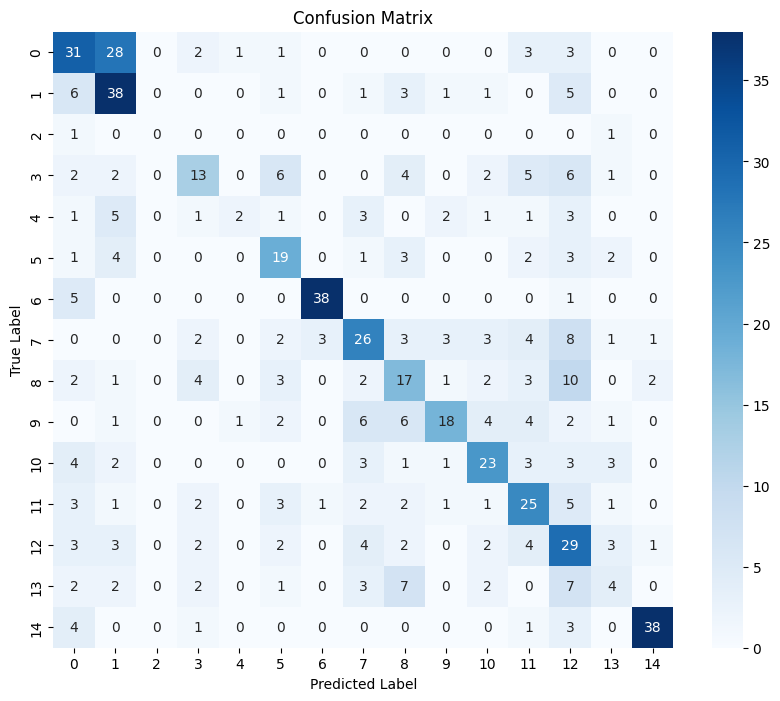

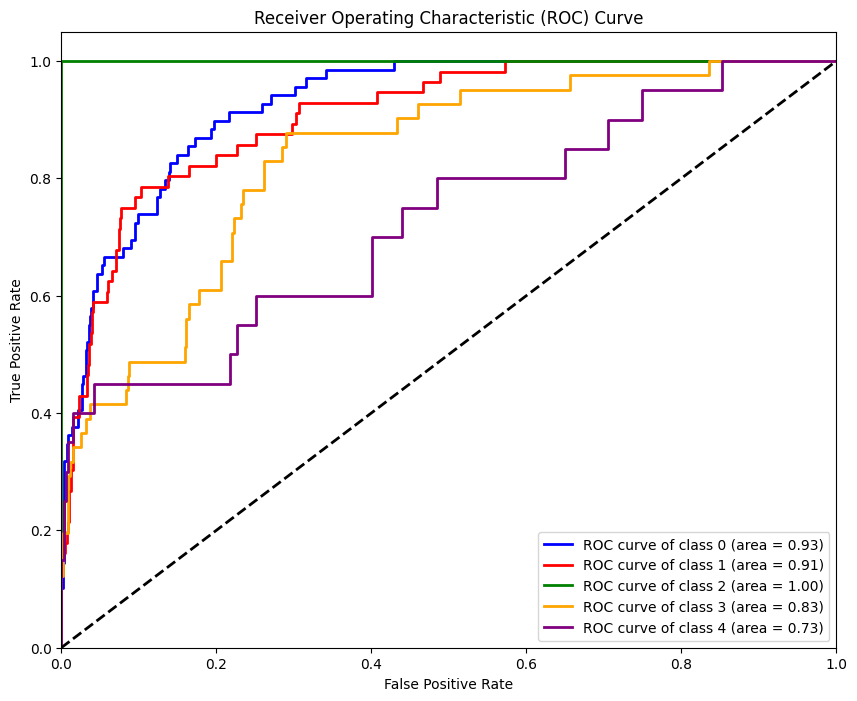

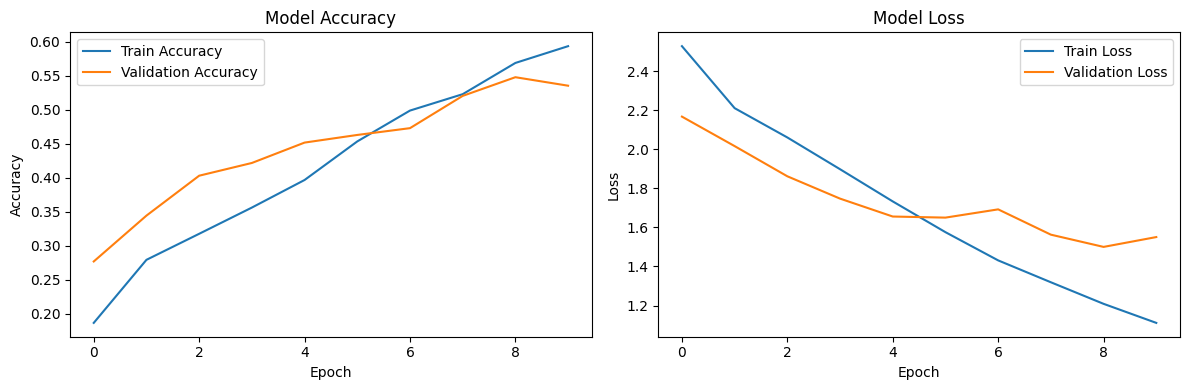

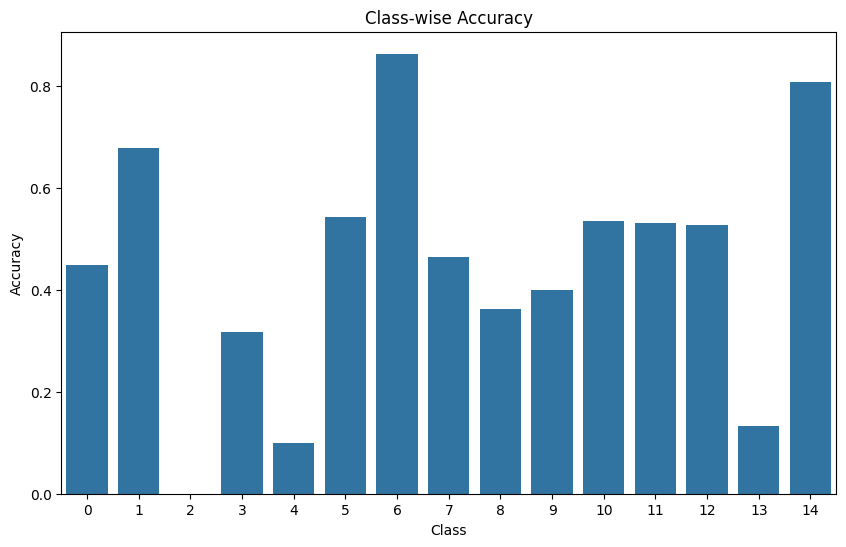

In [9]:
#Visualization & Accuracy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Assuming you've already trained your model and have your test dataset

# Get predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate accuracy
test_accuracy = np.mean(y_pred_classes == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC (for multi-class)
y_true_categorical = to_categorical(y_true)
n_classes = y_true_categorical.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_categorical[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Add more colors if needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Learning Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Class-wise Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(n_classes)), y=class_accuracy)
plt.title('Class-wise Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


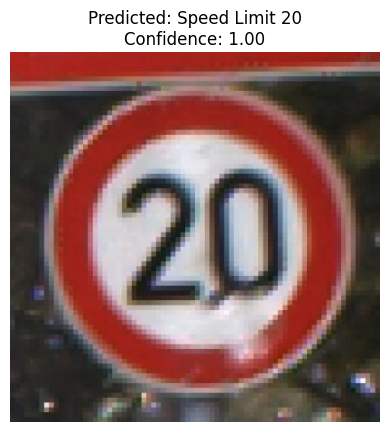

Predicted class: Speed Limit 20
Confidence: 1.00


In [15]:
#Model Testing
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the model
model_path = r'../notebooks/image_classification_model.h5'
model = tf.keras.models.load_model(model_path)

def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

def predict_image(model, image_path, class_names):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.title(f"Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.2f}")
    plt.show()
    
    return class_names[predicted_class], confidence

# Define your class names (replace with your actual class names)
class_names = ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110',
               'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50',
               'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']

# Test on a single image
image_path = "../data/test/images/00000_00000_00024_png.rf.8b21eb79678eed47df52a9ab4319bc08.jpg"
predicted_class, confidence = predict_image(model, image_path, class_names)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")